# Dados abertos e Ciência de Dados: a aprovação do Orçamento de Estado de 2021 através de dados abertos.

* Github: 👉 https://github.com/fsmunoz/pt-act-parlamentar/blob/master/OE2021.ipynb
* Jupyter Viewer: 👉 https://nbviewer.jupyter.org/github/fsmunoz/pt-act-parlamentar/raw/master/OE2021.ipynb
* PowerBI app: 👉 https://app.powerbi.com/view?r=eyJrIjoiODJjYzA4YTMtNGJhYi00ZTlhLTlkN2EtNDQ1ODFlZGI3ZWQ5IiwidCI6IjBiZmE4NTAwLWIxZjItNDU2Ni1iYWYxLTZmNTkzNzA4OTNlNyIsImMiOjh9
* Airtable 👉 https://airtable.com/shrrp72RkA993AlfG

## Introdução

*Este bloco de notas é um trabalho ao trabalho inicial que pode ser acedido em 👉 https://nbviewer.jupyter.org/github/fsmunoz/pt-act-parlamentar/raw/master/Actividade%20Parlamentar%20da%20XIV%20Legislatura.ipynb, e que descreve de forma detalhada todas as opções, com visibilidade de todo o código, explicação dos algoritmos utilizados e todo o processo de tratamento e exploração de dados; esta actualiação concentrar-se nos resultados e assume que quem deseja conhecer em maior detalhe os algoritmos irá consultar o trabalho original.*

*O resultado dos tratamento de dados e a listagem das votações é também disponibilização, para maior facilidade de análise independente, na "vista" de Airtable indicada acima.

A análise das votações e posicionamento relativo dos partidos tendo como base *exclusivamente* a forma como votam foi a base do trabalho anterior, análise essa que teve como fonte as votações das Iniciativas e Actividades.

O Orçamento de Estado para 2021 foi um acontecimento marcante da realidade política nacional do último trimestre de 2020 e que continuará a ter impactos na apreciação e debate político no futuro próximo: a posição dos vários partidos em termos de viabilização ou não do OE, as propostas que apresentaram e quem as aprovou ou recusou são matéria utilizada no debate para as Presidenciais, por exemplo.

Estas votações não estão incluídas na análise anterior: os dados utilizados relativs a votações no Parlamento não incluem, por exemplo, as votações feitas em Comissões. Esta actualização aborda um conjunto de votações independente, muito mais circunscrito no tempo e (dentro da grande variedade de temas abordados no OE) no conteúdo.

## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML [DadosAbertos] são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos)

São fundamentalmente feitas as seguintes análises:

1. Quantidade e tipo de propostas feitas, e resultado das mesmas
2. Apoio para as propostas de cada partido
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)

## Obtenção e tratamento dos dados

Esta fase é fundamental para toda a restante análise: é onde obtemos os dados e os transformamos em informação num formato que pode ser facilmente manipulado.

In [35]:
!pip3 install --user -q  matplotlib pandas seaborn sklearn

%matplotlib notebook

## Obtenção do ficheiro e conversão para dataframe

Os dados do OE encontram-se num ficheiro XML disponibilização na página do Parlamento:

In [36]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

oe_url = "http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379395063734f6e5957316c626e52764a5449775a47386c4d6a4246633352685a47387657456c574a5449775447566e61584e7359585231636d457654305651636d397762334e3059584e426248526c636d466a595738794d4449785433497565473173&fich=OEPropostasAlteracao2021Or.xml&Inline=true"
oe_tree = ET.parse(urlopen(oe_url))

## Propostas de alteração

Esse ficheiro contém a informação das proposts de alteração, votações e outros detalhes, dos quais extraímos alguns campos que consideramos essenciais para a análise; numa primeira fase obtemos os resultados das Propostas (e não das votações individuais que as compõe, como veremos mais à frente):

In [37]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

        oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print(vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Os dados são convertidos num *dataframe* pandas:

In [38]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df

,ID,Nr,Date,Domain,Type,State,GP,IniTitle,VoteDesc,Partido Socialista,...,Pessoas-Animais-Natureza,Chega,Iniciativa Liberal,V_Date,Result,Livre,"Partido Ecologista ""Os Verdes""",CRISTINA RODRIGUES(Ninsc),JOACINE KATAR MOREIRA(Ninsc),SARA MADRUGA DA COSTA(PSD)
0,14658,1440C,13/11/2020 20:08:00,Orçamento e Finanças,Aditamento (Números e Alíneas),Aprovado(a) em Comissão,PS,Investimento em infraestruturas de habitação p...,"N.º 3, Artigo 150.º",Favor,...,Favor,Abstenção,Abstenção,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1,14656,1439C,13/11/2020 19:59:00,Cultura e Comunicação,Por Definir,Retirado(a),PCP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14655,1438C,13/11/2020 19:59:00,"Educação, Ciência, Juventude e Desporto",Aditamento (Artigo PPL),Aprovado(a) Parcialmente em Comissão,PCP,Programa de apoio ao trabalho artístico e cult...,Artigo 171.º-A,Favor,...,Favor,Favor,Contra,25/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
3,14654,1437C,13/11/2020 19:59:00,Orçamento e Finanças,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Devolução de verbas do Fundo de Garantia Autom...,Artigo 207.º-A,Contra,...,Contra,Abstenção,Contra,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
4,14653,1436C,13/11/2020 19:58:00,Negócios Estrangeiros e Comunidades Portuguesas,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio às associações portuguesas no estrangeiro,Artigo 30.º-A,Contra,...,Favor,Favor,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,13152,5C,29/10/2020 09:02:00,Centro de recolha de animais,Emenda,Rejeitado(a) em Comissão,CRISTINA RODRIGUES,"Centros de recolha oficial de animais, apoio à...","N.º 1, Artigo 211.º",Contra,...,Favor,Favor,Favor,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1543,13151,4C,29/10/2020 09:02:00,"Ambiente, Energia e Ordenamento do Território",Aditamento (Artigo PPL),Aprovado(a) em Comissão,PEV,Avaliação ambiental estratégica para aferir me...,Artigo 196.º-A,Contra,...,Favor,Favor,Favor,24/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1544,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,"N.º 7, Artigo 114.º",Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1545,13149,2C,29/10/2020 09:01:00,"Administração Pública, Modernização Administra...",Substituição,Aprovado(a) em Comissão,PCP,Reforço de dotação do pessoal não docente na e...,Artigo 174.º,Favor,...,Favor,Favor,Contra,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN


Esta informação permite-nos desde já determinar a origem das propostas de alteração:

In [39]:
oe_df.groupby('GP')[['ID']].count().sort_values("ID", ascending=False)

,ID
GP,
PCP,352
PAN,266
CH,157
PEV,123
IL,115
CDS-PP,114
PSD,104
CRISTINA RODRIGUES,101
PS,79


E em gráfico de barras:

<IPython.core.display.Javascript object>


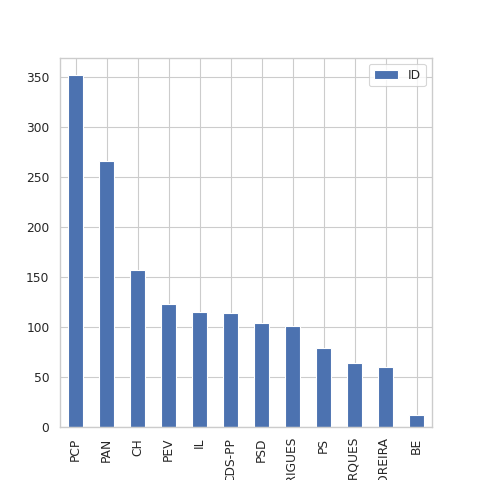

In [40]:

oe_df.groupby('GP')[['ID']].count().sort_values(by=['ID'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))



A quantidade total de propostas está em linha com os dados publicados ("Os partidos que viabilizaram o OE 2021, sem contar com o PS, entregaram 58% das propostas de alteração, com um total de 898 medidas. O PCP, que é decisivo na votação final, é o que mais quer mudar OE", https://eco.sapo.pt/2020/11/20/58-das-propostas-para-alterar-oe-2021-sao-dos-que-o-viabilizaram/).

Sabemos a quantidade total de propostas, mas quais foram aprovadas? Esta tabela indica os resultados das propostas de todos os partidos e deputados:

In [41]:
pd.crosstab(oe_df.GP, oe_df.State).columns

ct = pd.crosstab(oe_df.GP, oe_df.State)[['Aprovado(a) por Unanimidade em Plenário',
                                         'Aprovado(a) por Unanimidade em Comissão',
                                         'Aprovado(a) em Plenário',
                                         'Aprovado(a) em Comissão',
                                         'Aprovado(a) Parcialmente em Plenário',
                                         'Aprovado(a) Parcialmente em Comissão',
                                         'Entrada (via IPA)',
                                         'Aguarda Voto em Comissão',
                                         'Retirado(a)',
                                         'Prejudicado(a)',
                                         'Rejeitado(a) em Plenário',
                                         'Rejeitado(a) em Comissão'
                                        ]]
ct

GP,PCP,PS,PAN,PEV,PSD,JOACINE KATAR MOREIRA,CRISTINA RODRIGUES,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",CDS-PP,IL,BE,CH
State,,,,,,,,,,,,
Aguarda Voto em Comissão,1,0,0,0,1,0,1,0,0,0,0,0
Aprovado(a) Parcialmente em Comissão,11,0,5,4,2,0,1,0,1,0,0,0
Aprovado(a) Parcialmente em Plenário,2,0,0,1,4,0,0,0,0,0,0,0
Aprovado(a) em Comissão,61,52,45,26,23,11,8,8,6,0,0,0
Aprovado(a) em Plenário,0,2,0,0,0,0,0,0,0,2,1,0
Aprovado(a) por Unanimidade em Comissão,1,10,0,2,0,0,0,0,0,0,0,0
Aprovado(a) por Unanimidade em Plenário,0,2,0,0,0,0,0,0,0,0,0,0
Entrada (via IPA),1,0,0,0,0,0,0,0,0,0,0,0
Prejudicado(a),0,0,0,0,0,1,0,0,1,0,0,0


A mesma informação em forma de gráfico de barras: o total de propostas de cada partido (ou deputados) com a distribuição do resultado das mesmas, ordenados pelo maior número de aprovações.

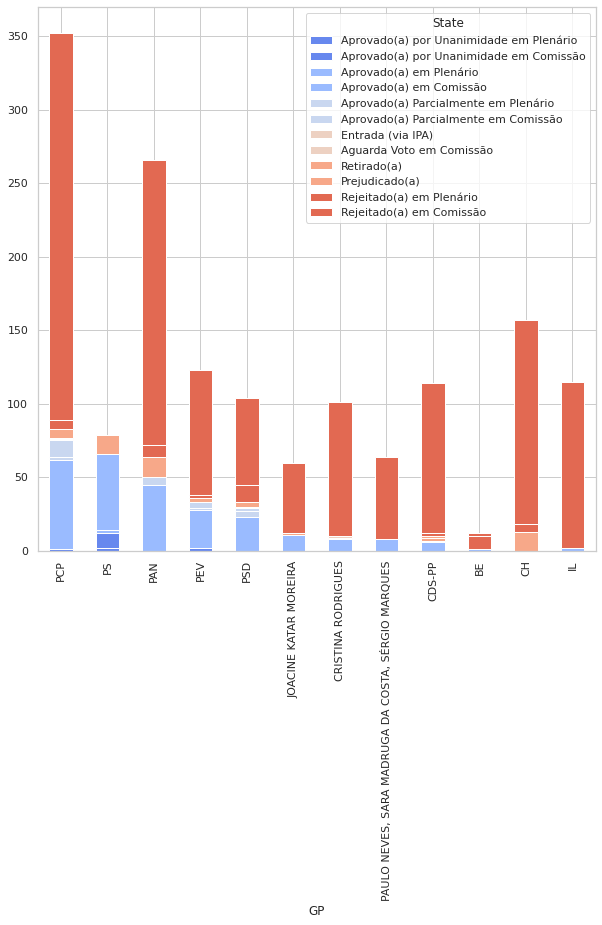

In [72]:
%matplotlib inline
#    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set()
sns.set_style("whitegrid")

## Sort by the "Approved in Comission" since this is >95% of the approved group and simplifies having to
## sort by a separate aggregate value.
ct.sort_values(by=['Aprovado(a) em Comissão'], ascending=False,axis=0).plot(kind="bar", stacked=True, colormap=ListedColormap(sns.color_palette("coolwarm").as_hex()),figsize=(10,10))


Algumas das leituras que se podem tirar desdes dados: 

* O maior número de propostas submetidas, rejeitadas mas também aprovadas é do PCP.
* O PS é o que tem uma percentagem de aprovação maior.
* CH não tem nenhuma. 
* Os restantes partidos e deputados têm a maioria das suas propostas rejeitadas e, em diferente número (BE tem 1 alteração aprovada), algumas aprovadas.

Estes resultados podem ser relacionados com o que foi a viabilização do OE: de facto os 4 primeiros partidos por número de alterações aprovadas são os que participaram na viabilização ("PS, PCP, PAN e PEV viabilizam OE 2021. BE e direita votam contra", https://eco.sapo.pt/2020/10/28/ps-pcp-pan-e-pev-viabilizam-oe-2021-be-e-direita-votam-contra/), sendo legítimo considerar que esse facto está directamente relacionado.

E que propostas cada partido conseguiu aprovar? A utilização do título da iniciativa é aqui útil

In [24]:
from IPython.display import display, HTML

approved_oe = oe_df[oe_df.State.str.contains("Aprovado")].fillna("")

for gp in approved_oe.GP.unique():
    gp_df = approved_oe[approved_oe["GP"]==gp][["GP","IniTitle", "VoteDesc", "State"]]
    print(gp + ": ", len(gp_df.index), " proposals approved:")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
        display(gp_df)



PS:  77  proposals approved:


,GP,IniTitle,VoteDesc,State
0,PS,Investimento em infraestruturas de habitação para profissionais das forças de segurança,,Aprovado(a) em Comissão
129,PS,Menores Refugiados Não Acompanhados,Artigo 144.º-A: Menores Refugiados Não Acompanhados,Aprovado(a) por Unanimidade em Comissão
163,PS,Alteração ao regime geral da gestão de resíduos e ao regime da contribuição extraordinária sobre o setor energético,Artigo 201.º-A: Alteração ao regime geral da gestão de resíduos e ao regime da contribuição extraordinária sobre o setor energético,Aprovado(a) em Comissão
189,PS,Alteração ao Código do Imposto sobre Veículos,,Aprovado(a) em Comissão
190,PS,Alteração ao Código do Imposto sobre Veículos,,Aprovado(a) em Comissão
193,PS,"Interconexão de dados entre a Agência para o desenvolvimento e Coesão, I.P (AD&C) e a Autoridade Tributária e Aduaneira (AT)","Artigo 218.º-A: Interconexão de dados entre a Agência para o desenvolvimento e Coesão, I.P (AD&C) e a Autoridade Tributária e Aduaneira (AT)",Aprovado(a) em Comissão
201,PS,Norma interpretativa em sede de IRS,Artigo 220.º-A: Norma interpretativa em sede de IRS,Aprovado(a) em Comissão
204,PS,Alteração ao Código do Imposto sobre o Rendimento das Pessoas Singulares,,Aprovado(a) em Comissão
209,PS,Alteração ao Código Fiscal do Investimento,,Aprovado(a) em Comissão
210,PS,Alteração ao Código Fiscal do Investimento,,Aprovado(a) em Comissão


PCP:  88  proposals approved:


,GP,IniTitle,VoteDesc,State
1,PCP,Programa de apoio ao trabalho artístico e cultural,Artigo 171.º-A: Programa de apoio ao trabalho artístico e cultural,Aprovado(a) Parcialmente em Comissão
11,PCP,Revisão do protocolo com o INEM e a ANEPC,Artigo 149.º-A: Revisão do protocolo com o INEM e a ANEPC,Aprovado(a) em Comissão
12,PCP,Internalização de Meios Complementares de Diagnóstico e Terapêutica,Artigo 183.º-A: Internalização de Meios Complementares de Diagnóstico e Terapêutica,Aprovado(a) Parcialmente em Comissão
14,PCP,Rendas de imóveis em centros comerciais,Artigo 139.º-A: Rendas de imóveis em centros comerciais,Aprovado(a) Parcialmente em Plenário
15,PCP,Rendas de imóveis em centros comerciais,Artigo 139.º-A: Rendas de imóveis em centros comerciais,Aprovado(a) Parcialmente em Plenário
19,PCP,Regime excecional de pagamento das rendas,Artigo 139.º-A: Regime excecional de pagamento das rendas,Aprovado(a) Parcialmente em Comissão
20,PCP,Garantia dos salários por inteiro,Artigo 136.º-A: Garantia dos salários por inteiro,Aprovado(a) em Comissão
34,PCP,Outras disposições no âmbito do Imposto sobre o Valor Acrescentado,,Aprovado(a) em Comissão
35,PCP,Plano Plurianual de Investimento na Investigação Criminal,Artigo 28.º-A: Plano Plurianual de Investimento na Investigação Criminal,Aprovado(a) em Comissão
46,PCP,Transferências orçamentais,,Aprovado(a) em Comissão


PAN:  52  proposals approved:


,GP,IniTitle,VoteDesc,State
16,PAN,"Dinamização do Registo Nacional de Profissionais do Sector das Atividades Artísticas, Culturais e de Espetáculo","Artigo 171.º-A: Dinamização do Registo Nacional de Profissionais do Sector das Atividades Artísticas, Culturais e de Espetáculo",Aprovado(a) em Comissão
25,PAN,Levantamento exaustivo do tecido cultural existente,Artigo 171.º-B: Levantamento exaustivo do tecido cultural existente,Aprovado(a) em Comissão
53,PAN,Transição de saldos da Lusa,Artigo 168.º-A: Transição de saldos da Lusa,Aprovado(a) em Comissão
95,PAN,"Contribuição sobre as embalagens de plástico, alumínio ou multimaterial com plástico ou com alumínio de utilização única adquiridas em refeições prontas a consumir, nos regimes de pronto a comer e levar ou com entrega ao domicílio, a aplicar-se a par","Artigo 154.º-A: Contribuição sobre as embalagens de plástico, alumínio ou multimaterial com plástico ou com alumínio de utilização única adquiridas em refeições prontas a consumir, nos regimes de pronto a comer e levar ou com entrega ao domicílio, a aplicar-se a par",Aprovado(a) em Comissão
100,PAN,Alteração ao Código do Imposto sobre Veículos,,Aprovado(a) em Comissão
101,PAN,Alteração ao Código do Imposto sobre o Rendimento das Pessoas Coletivas,,Aprovado(a) em Comissão
257,PAN,Regulamentação da profissão dos intérpretes de língua gestual,Artigo 39.º-A: Regulamentação da profissão dos intérpretes de língua gestual,Aprovado(a) em Comissão
278,PAN,Alteração ao Código dos Impostos Especiais de Consumo,,Aprovado(a) em Comissão
279,PAN,Alteração ao Código dos Impostos Especiais de Consumo,,Aprovado(a) em Comissão
299,PAN,Elaboração de estudo nacional sobre o impacto da distância percorrida pelos alimentos importados desde a sua produção ao consumo,Artigo 157.º-B: Elaboração de estudo nacional sobre o impacto da distância percorrida pelos alimentos importados desde a sua produção ao consumo,Aprovado(a) em Comissão


PSD:  33  proposals approved:


,GP,IniTitle,VoteDesc,State
40,PSD,Isenção dos emolumentos e outros encargos registais,Artigo 219.º-D: Isenção dos emolumentos e outros encargos registais,Aprovado(a) em Comissão
56,PSD,Apoio ao Património da Fundação Mata do Bussaco,Artigo 262.º-A: Apoio ao Património da Fundação Mata do Bussaco,Aprovado(a) em Comissão
68,PSD,Alargamento do prazo de adesão à moratória de crédito,Artigo 219.º-C: Alargamento do prazo de adesão à moratória de crédito,Aprovado(a) em Comissão
84,PSD,Certidão comprovativa de situação contributiva regularizada,Artigo 261.º-B: Certidão comprovativa de situação contributiva regularizada,Aprovado(a) em Comissão
85,PSD,Emissão certidão comprovativa de situação tributária,Artigo 261.º-A: Emissão certidão comprovativa de situação tributária,Aprovado(a) em Comissão
135,PSD,"Resgate de PPR, de PPE ou de PPR/E sem penalização","Artigo 219.º-A: Resgate de PPR, de PPE ou de PPR/E sem penalização",Aprovado(a) em Comissão
196,PSD,Fundo Resultante do Trespasse da Concessão das Barragens,Artigo 98.º-A: Fundo Resultante do Trespasse da Concessão das Barragens,Aprovado(a) Parcialmente em Comissão
214,PSD,Alteração ao Código dos Impostos Especiais de Consumo,,Aprovado(a) em Comissão
249,PSD,Alteração à lei-quadro das entidades reguladoras,Artigo 263.º-B: Alteração à lei-quadro das entidades reguladoras,Aprovado(a) em Comissão
250,PSD,Valor reforçado,,Aprovado(a) em Comissão


PEV:  36  proposals approved:


,GP,IniTitle,VoteDesc,State
102,PEV,"Realização de Avaliação Ambiental Estratégica de Mineração com especial ênfase sobre a prospeção, pesquisa e exploração de depósitos minerais de lítio e minerais associados","Artigo 199.º-G: Realização de Avaliação Ambiental Estratégica de Mineração com especial ênfase sobre a prospeção, pesquisa e exploração de depósitos minerais de lítio e minerais associados",Aprovado(a) Parcialmente em Comissão
162,PEV,Projetos sobre o Impacto da Poluição Luminosa no Ambiente,Artigo 198.º-B: Projetos sobre o Impacto da Poluição Luminosa no Ambiente,Aprovado(a) em Comissão
413,PEV,Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis,,Aprovado(a) em Comissão
414,PEV,Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis,,Aprovado(a) em Comissão
418,PEV,Alteração ao Código do Imposto Municipal sobre Imóveis,,Aprovado(a) em Comissão
419,PEV,Alteração ao Código do Imposto Municipal sobre Imóveis,,Aprovado(a) em Comissão
703,PEV,Estudo e substituição dos sistemas energéticos das escolas por outros mais sustentáveis,Artigo 198.º-A: Estudo e substituição dos sistemas energéticos das escolas por outros mais sustentáveis,Aprovado(a) em Comissão
808,PEV,Processo de construção da Escola Superior de Saúde do Instituto Politécnico de Setúbal,Artigo 172.º-A: Processo de construção da Escola Superior de Saúde do Instituto Politécnico de Setúbal,Aprovado(a) em Comissão
850,PEV,Incentivo à investigação do património cultural,,Aprovado(a) em Comissão
851,PEV,Incentivo à investigação do património cultural,,Aprovado(a) em Comissão


CDS-PP:  8  proposals approved:


,GP,IniTitle,VoteDesc,State
340,CDS-PP,Recrutamento de trabalhadores nas instituições de ensino superior públicas,,Aprovado(a) em Comissão
348,CDS-PP,Monitorização do abandono escolar e da ação social no Ensino Superior,Artigo 176.º-A: Monitorização do abandono escolar e da ação social no Ensino Superior,Aprovado(a) em Comissão
362,CDS-PP,Majoração do montante do subsídio de desemprego e do subsídio por cessação de atividade,,Aprovado(a) em Comissão
439,CDS-PP,Taxa Municipal de Direitos de Passagem e a Taxa Municipal de Ocupação de Subsolo,Artigo 240.º-A: Taxa Municipal de Direitos de Passagem e a Taxa Municipal de Ocupação de Subsolo,Aprovado(a) em Comissão
480,CDS-PP,Regime excecional das redes de faixas de gestão de combustível,,Aprovado(a) Parcialmente em Comissão
481,CDS-PP,Regime excecional das redes de faixas de gestão de combustível,,Aprovado(a) Parcialmente em Comissão
656,CDS-PP,"Contagem da avaliação obtida pelos ex-militares, nos anos em que desempenharam funções nas Forças Armadas, após ingresso na Administração Pública","Artigo 17.º-A: Contagem da avaliação obtida pelos ex-militares, nos anos em que desempenharam funções nas Forças Armadas, após ingresso na Administração Pública",Aprovado(a) em Comissão
690,CDS-PP,"Alteração à Lei n.º 10/2017, de 3 de março","Artigo 265.º-C: Alteração à Lei n.º 10/2017, de 3 de março",Aprovado(a) em Comissão


IL:  4  proposals approved:


,GP,IniTitle,VoteDesc,State
561,IL,Objeto,"Alínea d), N.º 1, Artigo 1.º: Mapa relativo à classificação orgânica das despesas do subsetor da Administração Central",Aprovado(a) em Plenário
562,IL,Objeto,"Alínea d), N.º 1, Artigo 1.º: Mapa relativo à classificação orgânica das despesas do subsetor da Administração Central",Aprovado(a) em Plenário
1416,IL,Portal da transparência do processo de execução dos fundos europeus,Artigo 175.º-A: Portal da transparência do processo de execução dos fundos europeus,Aprovado(a) em Plenário
1417,IL,Portal da transparência do processo de execução dos fundos europeus,Artigo 175.º-A: Portal da transparência do processo de execução dos fundos europeus,Aprovado(a) em Plenário


PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES:  8  proposals approved:


,GP,IniTitle,VoteDesc,State
800,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Centro de Produção da RTP-Madeira,Artigo 161.º-B: Centro de Produção da RTP-Madeira,Aprovado(a) em Comissão
802,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Plano de remodelação e construção de novas esquadras da Polícia de Segurança Pública na Região Autónoma da Madeira,Artigo 161.º-A: Plano de remodelação e construção de novas esquadras da Polícia de Segurança Pública na Região Autónoma da Madeira,Aprovado(a) em Comissão
810,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Reforço dos meios de combate a incêndios e de apoio às populações na Região Autónoma da Madeira,,Aprovado(a) em Comissão
820,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Redução de taxas aeroportuárias nos aeroportos da Madeira e do Porto Santo,Artigo 66.º-A: Redução de taxas aeroportuárias nos aeroportos da Madeira e do Porto Santo,Aprovado(a) em Comissão
821,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Cooperação Financeira entre o Estado e a Região Autónoma da Madeira com vista à concretização da Estratégia Regional de Habitação,Artigo 69.º-A: Cooperação Financeira entre o Estado e a Região Autónoma da Madeira com vista à concretização da Estratégia Regional de Habitação,Aprovado(a) em Comissão
822,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Alteração à Lista I anexa ao Código do IVA,Artigo 228.º-B: Alteração à Lista I anexa ao Código do IVA,Aprovado(a) em Comissão
837,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Instituições públicas de ensino superior das regiões autónomas,Artigo 172.º-B: Instituições públicas de ensino superior das regiões autónomas,Aprovado(a) em Comissão
841,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Subsídio de mobilidade social,Artigo 68.º-A: Subsídio de mobilidade social,Aprovado(a) em Comissão


JOACINE KATAR MOREIRA:  11  proposals approved:


,GP,IniTitle,VoteDesc,State
898,JOACINE KATAR MOREIRA,Estratégia Nacional para a Agricultura Biológica e Plano de Ação 2017-27,Artigo 205.º-A: Estratégia Nacional para a Agricultura Biológica e Plano de Ação 2017-27,Aprovado(a) em Comissão
1376,JOACINE KATAR MOREIRA,Campanha Nacional contra o abandono animal e de promoção da adoção consciente,Artigo 212.º-A: Campanha Nacional contra o abandono animal e de promoção da adoção consciente,Aprovado(a) em Comissão
1473,JOACINE KATAR MOREIRA,Inventariação de produtos que tenham na sua génese trabalho infantil ou trabalho forçado,Artigo 145.º-A: Inventariação de produtos que tenham na sua génese trabalho infantil ou trabalho forçado,Aprovado(a) em Comissão
1474,JOACINE KATAR MOREIRA,Execução de fundos na área da floresta,Artigo 157.º-A: Execução de fundos na área da floresta,Aprovado(a) em Comissão
1489,JOACINE KATAR MOREIRA,Alteração ao Estatuto dos Benefícios Fiscais,,Aprovado(a) em Comissão
1498,JOACINE KATAR MOREIRA,Regulamentação da Lei Orgânica e do Estatuto de Pessoal da Polícia Judiciária,Artigo 35.º-A: Regulamentação da Lei Orgânica e do Estatuto de Pessoal da Polícia Judiciária,Aprovado(a) em Comissão
1504,JOACINE KATAR MOREIRA,Plano nacional para a inclusão digital,Artigo 25.º-A: Plano nacional para a inclusão digital,Aprovado(a) em Comissão
1507,JOACINE KATAR MOREIRA,Implementação do Plano Plurianual de Investimentos para o Serviço Nacional de Saúde e do Plano Nacional de Saúde Mental,,Aprovado(a) em Comissão
1512,JOACINE KATAR MOREIRA,"Observatório Independente do Discurso de Ódio, Racismo e Xenofobia","Artigo 46.º-A: Observatório Independente do Discurso de Ódio, Racismo e Xenofobia",Aprovado(a) em Comissão
1525,JOACINE KATAR MOREIRA,Estratégia Nacional para a Integração das Pessoas em Situação de Sem-Abrigo 2017-2023,,Aprovado(a) em Comissão


CRISTINA RODRIGUES:  9  proposals approved:


,GP,IniTitle,VoteDesc,State
1162,CRISTINA RODRIGUES,"Projecto-piloto de diagnóstico, apoio e acompanhamento a pessoas em situação de prostituição","Artigo 145.º-A: Projecto-piloto de diagnóstico, apoio e acompanhamento a pessoas em situação de prostituição",Aprovado(a) em Comissão
1176,CRISTINA RODRIGUES,Contratação de Médicos Veterinários Municipais,Artigo 212.º-A: Contratação de Médicos Veterinários Municipais,Aprovado(a) Parcialmente em Comissão
1337,CRISTINA RODRIGUES,Sustentabilidade na produção de biocombustíveis,Artigo 200.º-A: Sustentabilidade na produção de biocombustíveis,Aprovado(a) em Comissão
1370,CRISTINA RODRIGUES,Remoção do lixo marinho,Artigo 209.º-A: Remoção do lixo marinho,Aprovado(a) em Comissão
1373,CRISTINA RODRIGUES,Incentivo ao abate de artes de pesca mais lesivas do ambiente marinho,Artigo 209.º-A: Incentivo ao abate de artes de pesca mais lesivas do ambiente marinho,Aprovado(a) em Comissão
1403,CRISTINA RODRIGUES,Reforço dos Centros de PMA,Artigo 183.º-A: Reforço dos Centros de PMA,Aprovado(a) em Comissão
1414,CRISTINA RODRIGUES,Combate ao desperdício alimentar,Artigo 210.º-A: Combate ao desperdício alimentar,Aprovado(a) em Comissão
1486,CRISTINA RODRIGUES,Apoios às pequenas e médias editoras independentes,Artigo 170.º-A: Apoios às pequenas e médias editoras independentes,Aprovado(a) em Comissão
1499,CRISTINA RODRIGUES,Monitorização e remoção de resíduos de artes de pesca,Artigo 209.º-A: Monitorização e remoção de resíduos de artes de pesca,Aprovado(a) em Comissão


BE:  2  proposals approved:


,GP,IniTitle,VoteDesc,State
1209,BE,Objeto,"Alínea d), N.º 1, Artigo 1.º: Mapa relativo à classificação orgânica das despesas do subsetor da Administração Central",Aprovado(a) em Plenário
1210,BE,Objeto,"Alínea d), N.º 1, Artigo 1.º: Mapa relativo à classificação orgânica das despesas do subsetor da Administração Central",Aprovado(a) em Plenário


## Votações

Até agora contabilizámos as propostas de alteração e o seu resultado; se em geral existe uma votação por proposta de alteração isso nem sempre acontece: existem propostas de alteração que dão origem a mais que uma votação. As votações contêm informação adicional que é interessante para de determinar de forma directa o teor das propostas (nomeadamente o título) e também a forma como os diferentes partidos e deputados votaram: se ao nível das propostas temos o resultado final, com as votações podemos saber como atingiram esse fim.

Para obtermos esses dados modificamos o processamento de forma a tratar todas as votações:

In [25]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "SubDescricao":
                    oe_dict["SubDesc"] = vote_el.text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

            oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print("Voting sessions:", vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

A informação recolhida é convertida numa tabela (*dataframe*):

In [26]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df
oe_df["VoteDesc"] = oe_df["VoteDesc"] + ": " + oe_df["SubDesc"]
oe_df.drop(['SubDesc'],axis=1,inplace=True)
oe_df

,ID,Nr,Date,Domain,Type,State,GP,IniTitle,VoteDesc,Partido Socialista,...,Pessoas-Animais-Natureza,Chega,Iniciativa Liberal,V_Date,Result,Livre,"Partido Ecologista ""Os Verdes""",CRISTINA RODRIGUES(Ninsc),JOACINE KATAR MOREIRA(Ninsc),SARA MADRUGA DA COSTA(PSD)
0,14658,1440C,13/11/2020 20:08:00,Orçamento e Finanças,Aditamento (Números e Alíneas),Aprovado(a) em Comissão,PS,Investimento em infraestruturas de habitação p...,NaN,Favor,...,Favor,Abstenção,Abstenção,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1,14655,1438C,13/11/2020 19:59:00,"Educação, Ciência, Juventude e Desporto",Aditamento (Artigo PPL),Aprovado(a) Parcialmente em Comissão,PCP,Programa de apoio ao trabalho artístico e cult...,Artigo 171.º-A: Programa de apoio ao trabalho ...,Favor,...,Favor,Favor,Contra,25/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
2,14654,1437C,13/11/2020 19:59:00,Orçamento e Finanças,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Devolução de verbas do Fundo de Garantia Autom...,Artigo 207.º-A: Devolução de verbas do Fundo d...,Contra,...,Contra,Abstenção,Contra,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
3,14653,1436C,13/11/2020 19:58:00,Negócios Estrangeiros e Comunidades Portuguesas,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio às associações portuguesas no estrangeiro,Artigo 30.º-A: Apoio às associações portuguesa...,Contra,...,Favor,Favor,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
4,14652,1435C,13/11/2020 19:58:00,Assuntos Europeus,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio à retoma das atividades das associações ...,Artigo 164.º-A: Apoio à retoma das atividades ...,Contra,...,Favor,Favor,Abstenção,23/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,NaN,Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1642,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,NaN,Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1643,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,NaN,Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1644,13149,2C,29/10/2020 09:01:00,"Administração Pública, Modernização Administra...",Substituição,Aprovado(a) em Comissão,PCP,Reforço de dotação do pessoal não docente na e...,Artigo 174.º: Reforço de dotação do pessoal nã...,Favor,...,Favor,Favor,Contra,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN


Para uniformizar a informação convertemos os nomes das colunas que indicam os nomes do partidos por extenso nas abreviaturas utilizadas na indicação do autor das propostas.

In [27]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
oe_dfr = oe_df.rename(columns={'Partido Socialista': 'PS', 
                               'Partido Social Democrata': 'PSD',
                               'Bloco de Esquerda': 'BE',
                               'Partido Comunista Português': 'PCP',
                               'Centro Democrático Social - Partido Popular': 'CDS-PP',
                               'Pessoas-Animais-Natureza': 'PAN',
                               'Chega': 'CH',
                               'Iniciativa Liberal':'IL',
                               'Partido Ecologista "Os Verdes"':'PEV',
                               'Livre':'L',
                               'CRISTINA RODRIGUES(Ninsc)': 'CR',
                               'JOACINE KATAR MOREIRA(Ninsc)': 'JKM'
                               
                              })
oe_dfr.replace("CRISTINA RODRIGUES","CR", inplace=True)
oe_dfr.replace("JOACINE KATAR MOREIRA","JKM", inplace=True)

oe_dfr.head()
                      

,ID,Nr,Date,Domain,Type,State,GP,IniTitle,VoteDesc,PS,...,PAN,CH,IL,V_Date,Result,L,PEV,CR,JKM,SARA MADRUGA DA COSTA(PSD)
0,14658,1440C,13/11/2020 20:08:00,Orçamento e Finanças,Aditamento (Números e Alíneas),Aprovado(a) em Comissão,PS,Investimento em infraestruturas de habitação p...,NaN,Favor,...,Favor,Abstenção,Abstenção,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1,14655,1438C,13/11/2020 19:59:00,"Educação, Ciência, Juventude e Desporto",Aditamento (Artigo PPL),Aprovado(a) Parcialmente em Comissão,PCP,Programa de apoio ao trabalho artístico e cult...,Artigo 171.º-A: Programa de apoio ao trabalho ...,Favor,...,Favor,Favor,Contra,25/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
2,14654,1437C,13/11/2020 19:59:00,Orçamento e Finanças,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Devolução de verbas do Fundo de Garantia Autom...,Artigo 207.º-A: Devolução de verbas do Fundo d...,Contra,...,Contra,Abstenção,Contra,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
3,14653,1436C,13/11/2020 19:58:00,Negócios Estrangeiros e Comunidades Portuguesas,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio às associações portuguesas no estrangeiro,Artigo 30.º-A: Apoio às associações portuguesa...,Contra,...,Favor,Favor,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
4,14652,1435C,13/11/2020 19:58:00,Assuntos Europeus,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio à retoma das atividades das associações ...,Artigo 164.º-A: Apoio à retoma das atividades ...,Contra,...,Favor,Favor,Abstenção,23/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN


Para a análise das votações escolhemos um subconjunto alargado dos autores das propostas, isto porque nem todos os partidos estão presentes na Comissão de Orçamento e Finanças e, por outro lado, as propostas de deputados individuais ou em grupo necessitaria de um tratamento mais complexo.
O resultado é uma tabela com a indicação do autor da proposta onde se integra a votação e os votos dos partidos.

In [28]:
mycol  = ['GP', 'BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR', 'PSD','IL','CDS-PP', 'CH' ]
parties   = ['BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR','PSD','IL','CDS-PP', 'CH']
df=oe_dfr

submissions_ini = df[mycol]
submissions_ini.head()

,GP,BE,PCP,PEV,JKM,PS,PAN,CR,PSD,IL,CDS-PP,CH
0,PS,Abstenção,Favor,NaN,NaN,Favor,Favor,NaN,Abstenção,Abstenção,Favor,Abstenção
1,PCP,Favor,Favor,NaN,NaN,Favor,Favor,NaN,Abstenção,Contra,Abstenção,Favor
2,PCP,Favor,Favor,NaN,NaN,Contra,Contra,NaN,Contra,Contra,Abstenção,Abstenção
3,PCP,Favor,Favor,NaN,NaN,Contra,Favor,NaN,Abstenção,Contra,Abstenção,Favor
4,PCP,Favor,Favor,NaN,NaN,Contra,Favor,NaN,Abstenção,Abstenção,Abstenção,Favor


Com esta informação é possível determinar os padrões de votação: para cada partido é criado um gráfico de barras, ordenado pelos votos favoráveis, com  comportamento de votos dos restantes para com as suas propostas.

BE


<IPython.core.display.Javascript object>


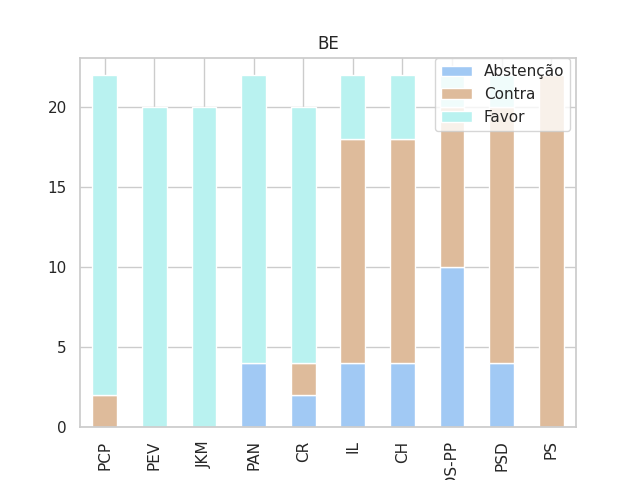

PCP


<IPython.core.display.Javascript object>


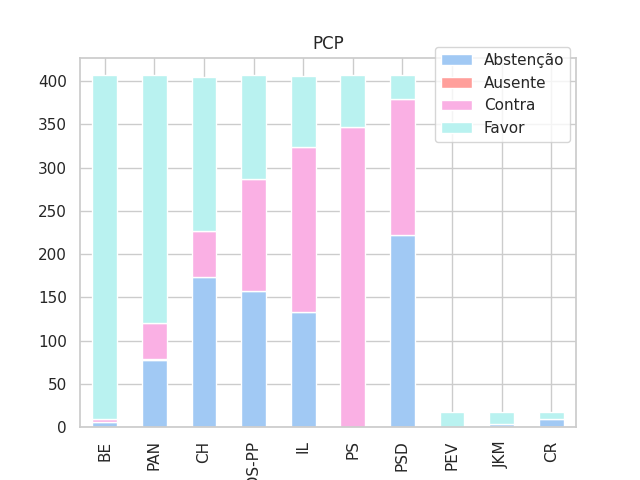

PEV


<IPython.core.display.Javascript object>


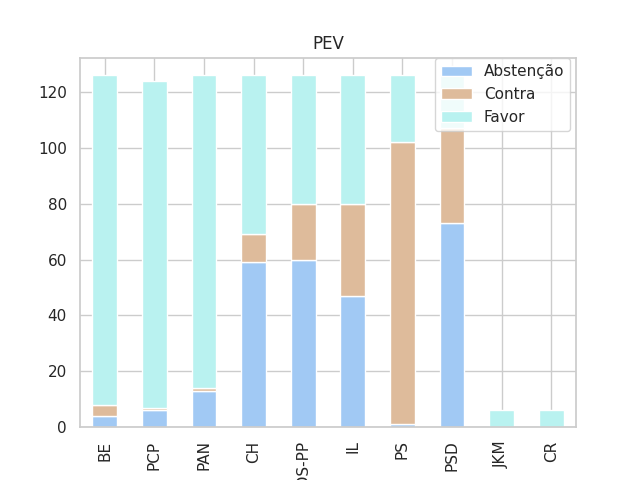

JKM


<IPython.core.display.Javascript object>


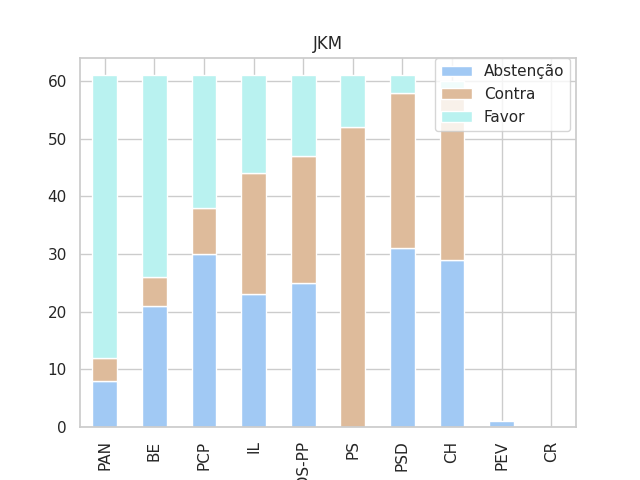

PS


<IPython.core.display.Javascript object>


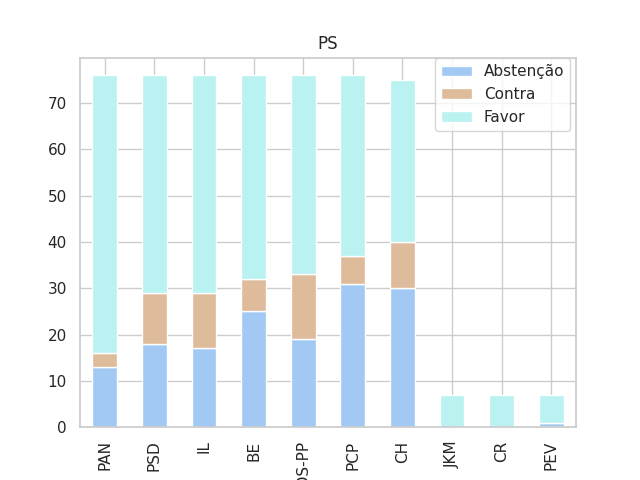

PAN


<IPython.core.display.Javascript object>


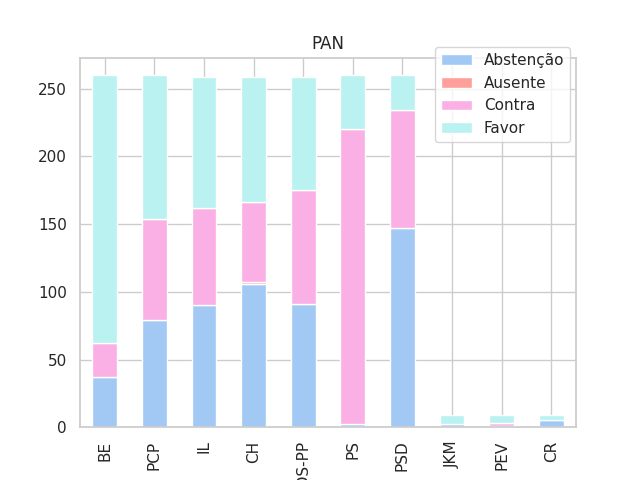

CR


<IPython.core.display.Javascript object>


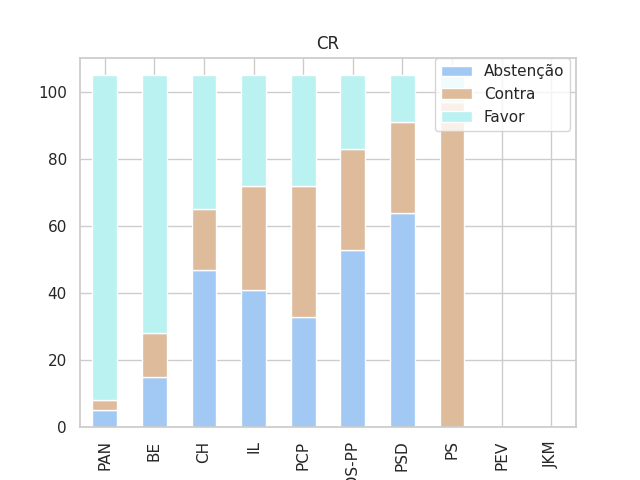

PSD


<IPython.core.display.Javascript object>


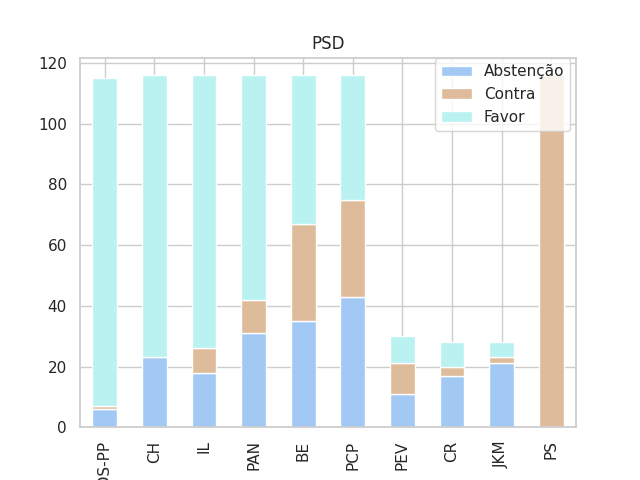

IL


<IPython.core.display.Javascript object>


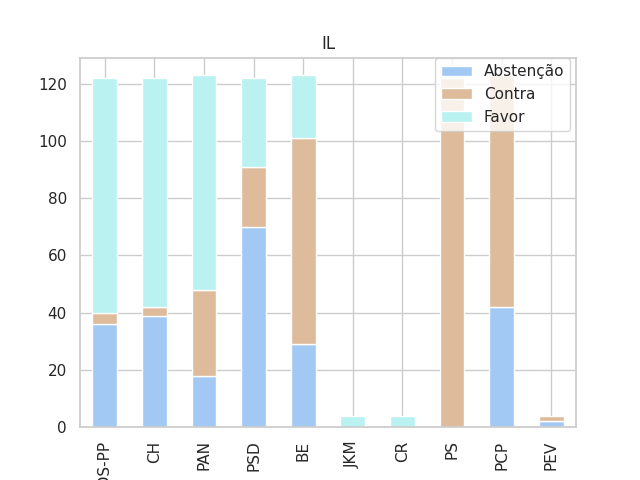

CDS-PP


<IPython.core.display.Javascript object>


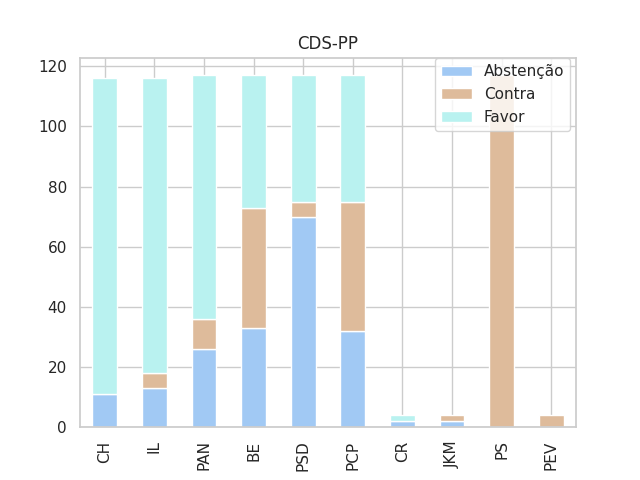

CH


<IPython.core.display.Javascript object>


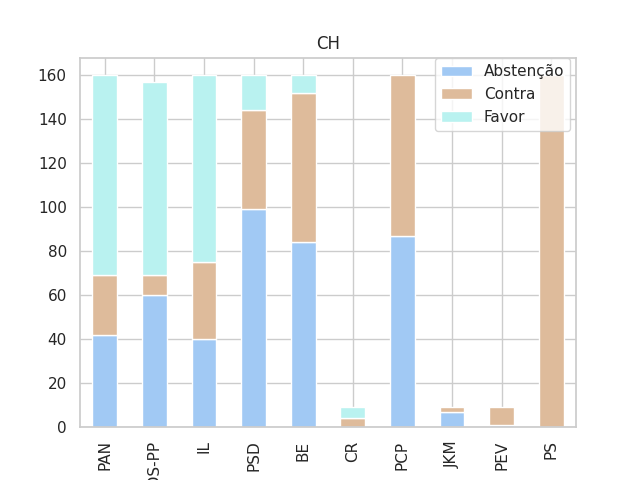

In [29]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())

for party in parties:
    print(party)
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap)
    plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.9))
    plt.show()


## MDS: *Multidimensional scaling*

Tendo como base os votos no OE podemos utilizar a mesma técnica que empregámos na análise de toda a legislatura: 



In [30]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import numpy as np
votes_hm = oe_dfr[['BE', 'PCP', 'PEV', 'JKM', 'PS', 'PAN', 'CR', 'PSD','IL','CDS-PP', 'CH']]
votes_hmn = votes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0)
votes_hmn.drop('PEV', axis=1, inplace=True)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

## Affinity matrix
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)

#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)

Para identificar grupos usamos (mais uma vez, como no trabalho original a que remetemos para todos os detalhes) *Spectrum scaling*, definindo 4 grupos.

In [31]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

print(sc_dict)

{'BE': 2, 'PCP': 2, 'JKM': 0, 'PS': 3, 'PAN': 0, 'CR': 0, 'PSD': 1, 'IL': 1, 'CDS-PP': 1, 'CH': 1}


O resultado aparente resultar numa divisão "esquerda/centro/direita", com o PS numa posição individual; tal como referido não será indiferente o facto do PS ser o partido que suporta o Governo.

Esta separação pode ser vista também em termos de agrupamento e proximidade relativa:

<IPython.core.display.Javascript object>


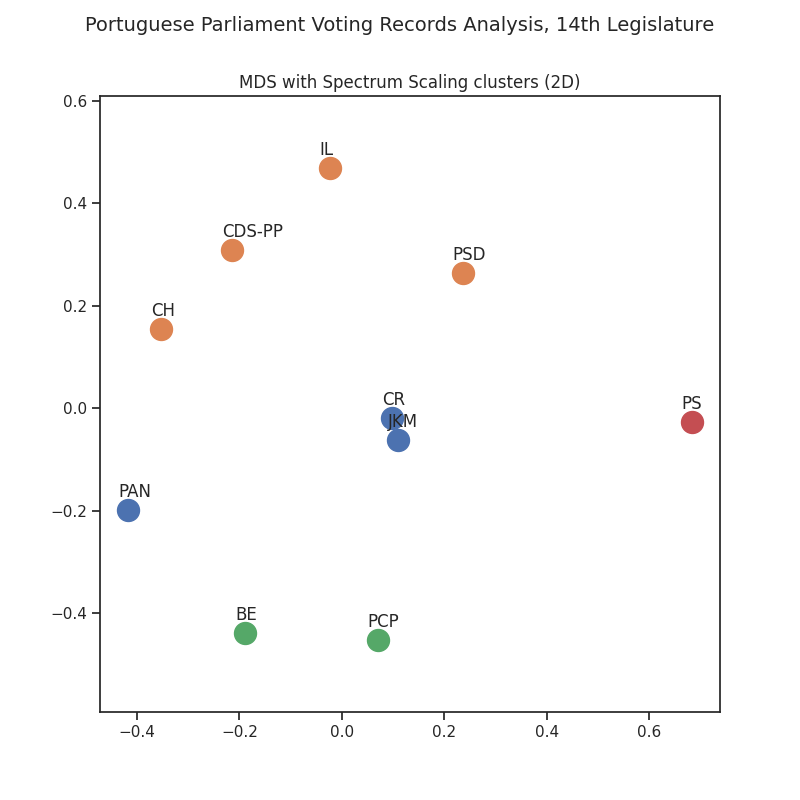

In [32]:
from sklearn.manifold import MDS
import random
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

O resultado aqui quase mapeia a viabilização do OE: o PS enquanto partido de suporte ao Governo, os partidos à sua direita e os à sua esquerda - e o "quase" é exactamente aqui, visto o BE ter votado de forma próxima, nas votações individuais, a partidos que viabilizaram o OE, sem no entanto o ter feito.

Uma visualização em 3D adiciona uma dimensão 

<IPython.core.display.Javascript object>


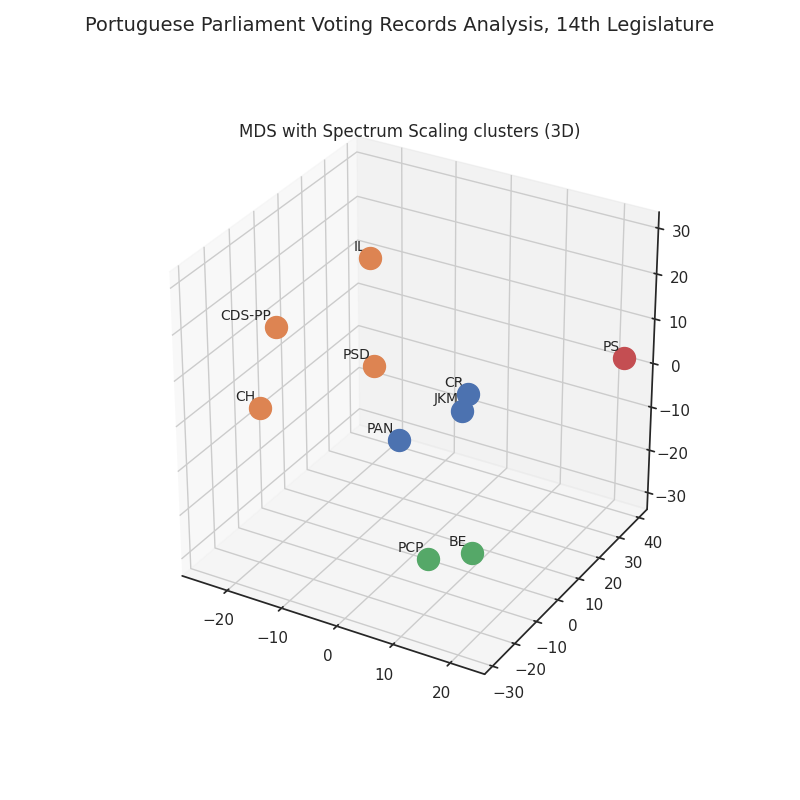

In [18]:
from sklearn.manifold import MDS
import mpl_toolkits.mplot3d
import random

## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    #print(label,pmds_colors[label])
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()


## Palavras finais

Esta análise demonstra como a utilização de dados abertos pode, uma vez mais, facilitar a análise da actividade parlamentar por parte dos eleitores; as ilações políticas que se podem tirar são variadas e, se é verdade que existem limitações várias a ter em conta, tal como no trabalho relativo à análise das votações parlamentares parecem emergir padrões que parecem reflectir tendências e agrupamentos que estão presentes no discurso político.

---
***2021, Frederico Muñoz***

## Apêndice
### How to cite this notebook
MUÑOZ, Frederico Serrano - Dados abertos e Ciência de Dados: a aprovação do Orçamento de Estado de 2020 através de dados abertos. [Online] WWW: 